# Yukti Patil 
# Etivity 5: Regression and Dimensionality Reduction
### In this exercise, we aim at training a regression model for predicting the insurance_cost from its other characteristics. We will evaluate 3 regression algorithms, 'RandomForestRegressor', 'LinearRegression' and 'Gradient Boost Regressor' to choose the better one for training the final model. We use filter and wrapper methods of the dimensionality reduction techniques and find out the one which the best found technique using Grid Search CV. We inspect the results of the reduction technique.

# 1. Import all Libraries

In [207]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD, FactorAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns

# 2. EDA

In [150]:
df = pd.read_csv("./insurance.csv")
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


## 2.1. Checking the numerical and categorical values

In [151]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Describe ignores the categorical columns, We can tell .describe() to do the opposite by passing 'number' to the 'exclude' argument.

In [152]:
df.describe(exclude='number')

,gender,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


### From the statistical summary, even if we se min values for children is 0, and 25% contains 0. It is a valid values in case of children so we do not need to drop the feature.
### Looking at the summary for categorical columns, we can check the top values in each. Also let us check the value counts if any of the class categories could be eliminated

In [153]:
print(df['region'].value_counts(),'\n\n',df['gender'].value_counts(),'\n\n',df['children'].value_counts(),'\n\n',df['smoker'].value_counts())

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64 

 male      676
female    662
Name: gender, dtype: int64 

 0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64 

 no     1064
yes     274
Name: smoker, dtype: int64


### Looking at the value counts for each class categories, we do not need to eliminate any of the rows.

## 2.2. Check Missing and null values

In [154]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

## 2.3. Let us try and apply t-Distributed Stochastic Neighbor Embedding or t-SNE to visualize the high dimensional data using feature extraction.t-SNE will maximize the distance in two-dimensional space between observations that are most different in a high-dimensional space. 

In [155]:
non_numeric = ['gender','smoker','region']
df_numeric= df.drop(non_numeric,axis=1)
df_numeric.shape 

#t-SNE does  not work with non-numeric data
#instead ofone hot coding, we can create tsnemodel

(1338, 4)

In [156]:
from sklearn.manifold import TSNE
m=TSNE(learning_rate=50)
#fit and transform the TSNE model to our numeic dataset
tsne_features =m.fit_transform(df_numeric)
tsne_features[1:4,:]

array([[ 19.724073 ,  44.18418  ],
       [  0.3964735,  34.309616 ],
       [-31.020317 , -26.587791 ]], dtype=float32)

In [157]:
df['x'] =tsne_features[:,0]
df['y']=tsne_features[:,1]

<ipython-input-158-d560572e1172>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


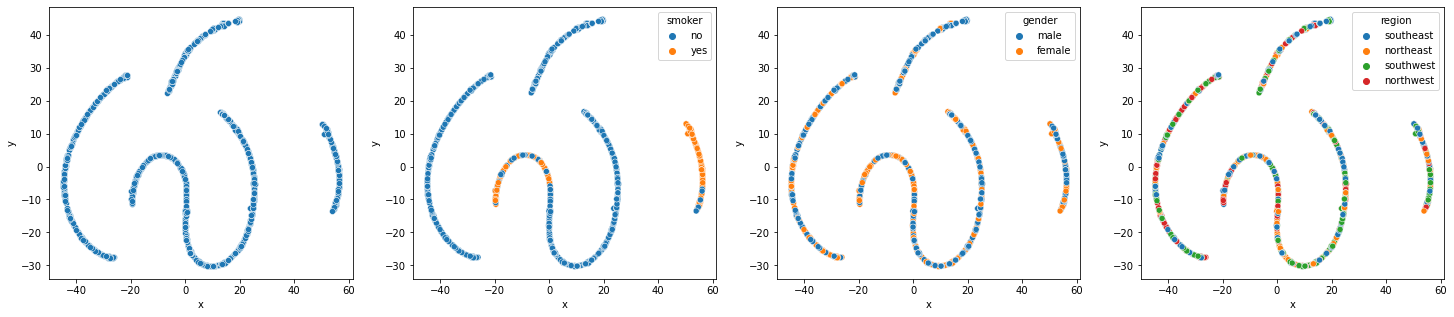

In [158]:
fig, ax =plt.subplots(1,4,figsize=(25,5))
sns.scatterplot(x='x',y='y',data=df,ax=ax[0])
sns.scatterplot(x='x',y='y',hue='smoker',data=df,ax=ax[1])
sns.scatterplot(x='x',y='y',hue='gender',data=df,ax=ax[2])
sns.scatterplot(x='x',y='y',hue='region',data=df,ax=ax[3])
fig.show()

### The resultant plot does not show one big cluster, this explains a lot of varinace in the dataset with all the features.

### Coloring points according the 'smoker' category shows us smokers are to left and right of tghe plot, indicating higher insurance costs.

## 2.4. Check box plots to check any outliers

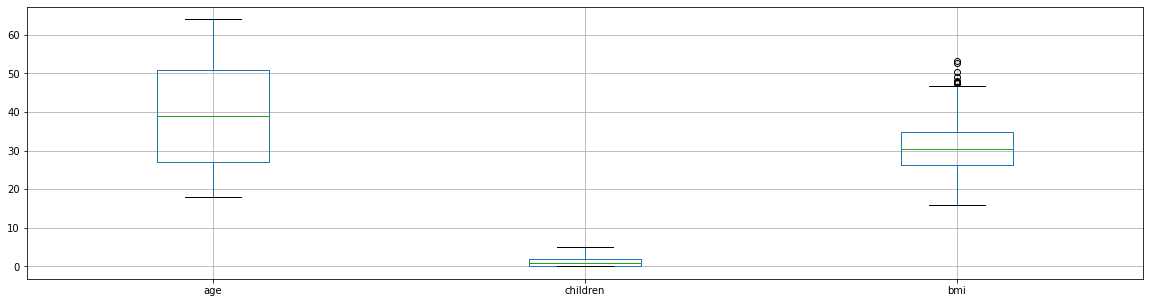

In [159]:
df[['age','children','bmi']].boxplot(figsize=(20,5))
plt.show()

### There are some outliers for the bmi column

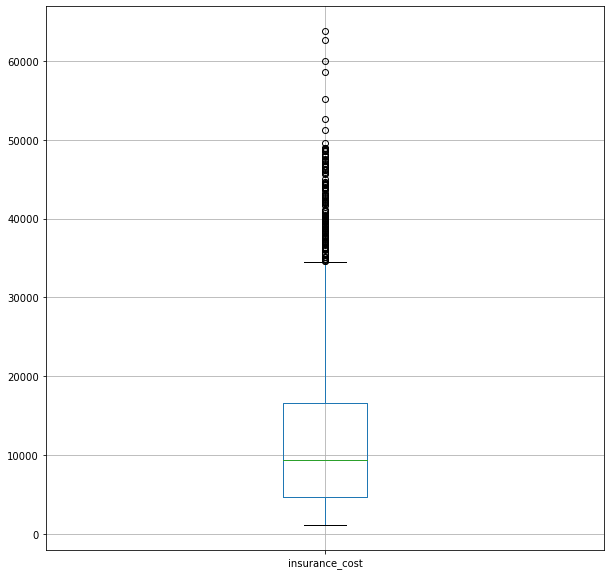

In [160]:
df.boxplot(column=['insurance_cost'],figsize=(10,10))
plt.show()

### The outliers in the insurance_cost are acceptable since the higher amount is possible for an individual.

# 3. Data Preparation

### Now, we shall replace the categorical column `gender`,`smoker` and `region` by multiple numerical columns. Since the names of the above do not have order, we will use `one-hot encoding` to do this. 

In [161]:
mapper = {'male': 1, 'female': 0}
df['gender'] = df['gender'].replace(mapper)
df['gender'].value_counts()

1    676
0    662
Name: gender, dtype: int64

In [162]:
mapper2 = {'yes': 1, 'no': 0}
df['smoker'] = df['smoker'].replace(mapper2)
df['smoker'].value_counts()

0    1064
1     274
Name: smoker, dtype: int64

In [163]:
df = pd.get_dummies(df, columns=['gender','region','smoker'], 
                        #dummy_na=True, 
                        drop_first=True)

### Transformed dataset

In [164]:
df.head()

,age,bmi,children,insurance_cost,x,y,gender_1,region_northwest,region_southeast,region_southwest,smoker_1
0,18,33.770,1,1725.55230,10.314191,41.515537,1,0,1,0,0
1,18,34.100,0,1137.01100,19.724073,44.184181,1,0,1,0,0
2,18,26.315,0,2198.18985,0.396473,34.309616,0,0,0,0,0
3,18,38.665,2,3393.35635,-31.020317,-26.587791,0,0,0,0,0
4,18,35.625,0,2211.13075,-0.265285,34.247086,0,0,0,0,0


In [170]:
df=df.drop(['x','y'],axis=1)
df

,age,bmi,children,insurance_cost,gender_1,region_northwest,region_southeast,region_southwest,smoker_1
0,18,33.770,1,1725.55230,1,0,1,0,0
1,18,34.100,0,1137.01100,1,0,1,0,0
2,18,26.315,0,2198.18985,0,0,0,0,0
3,18,38.665,2,3393.35635,0,0,0,0,0
4,18,35.625,0,2211.13075,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1333,64,31.825,2,16069.08475,0,0,0,0,0
1334,64,26.885,0,29330.98315,0,1,0,0,1
1335,64,26.410,0,14394.55790,1,0,0,0,0
1336,64,36.960,2,49577.66240,1,0,1,0,1


In [171]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['insurance_cost']]

# define column groups with same data preparation
names_outliers = ['bmi']

names_no_outliers = list(set(names_all) - set(names_outliers))

print(names_outliers)
print(names_no_outliers)
print(names_all)

['bmi']
['gender_1', 'region_southeast', 'smoker_1', 'region_northwest', 'children', 'region_southwest', 'age']
['age', 'bmi', 'children', 'gender_1', 'region_northwest', 'region_southeast', 'region_southwest', 'smoker_1']


### In the class below we will write the logic to put the columns back when they are lost after splitting it into training and test datasets

In [172]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

### Also, another class to be able to select the columns.

In [173]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

### Finally, we can build a preprocessing pipeline. Firstly, it adds columns back to the set of examples. Post that the two different data transformation techniques are applied to those columns and then columns are merged using feature union.

In [174]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

### Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [175]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [176]:
X_train.shape

(1070, 8)

# 4. Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, we train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we will build another [main] pipeline which includes the preprocessing pipeline and `RandomForestRegressor`. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we will attempt three different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

## 4.1. Random Forest Pipeline
The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the three methods.

In [191]:
pipe_rf = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [193]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe_rf, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.873:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 4}


## 4.1.2 Inspect the RFE results, as it isthe best dimensionality reduction technique found using Grid Search CV above                 

In [194]:
rfe =RFE(estimator=svm.SVR(gamma='auto', kernel='linear'), n_features_to_select=11)
rfe.fit(X_train,y_train)
rfe_list=[]
for i in range(X.shape[1]):
    col_list = [df.columns[i],rfe.support_[i],rfe.ranking_[i]]
    rfe_list.append(col_list)
rfe_df = pd.DataFrame(rfe_list,columns=['Column','Selected','Rank'])
rfe_df.head(10)

,Column,Selected,Rank
0,age,True,1
1,bmi,True,1
2,children,True,1
3,insurance_cost,True,1
4,gender_1,True,1
5,region_northwest,True,1
6,region_southeast,True,1
7,region_southwest,True,1


### support_ attribute contains True/False values to see which features were kept in the dataset
### ranking_ attribute is to see in which iteration a feature was dropped
### Values of 1 mean that the feature was kept in the dataset until the end while high values mean the feature was dropped early on.

### For the dataset all the features were kept until the end and all features have an impact on the model and its predictions.

## 4.2. Linear Regression Pipeline

In [195]:
pipe_lr = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

Again we limit the parameter grid to one parameter of `LinearRegression` and three alternative values for the number of selected features to make sure the grid search does not take too long to execute.

In [196]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.756:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': True}


The results suggest that Random Forest performs better. The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model. We can now further confirm this by comparing the best models on the test set.

## 4.3. Compare regression models on test set
Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [197]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

We will use the function above to evaluate the best Random Forest and Linear Regression models found by the grid search.

In [198]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

We will use a Pandas bar plots to compare the results. 

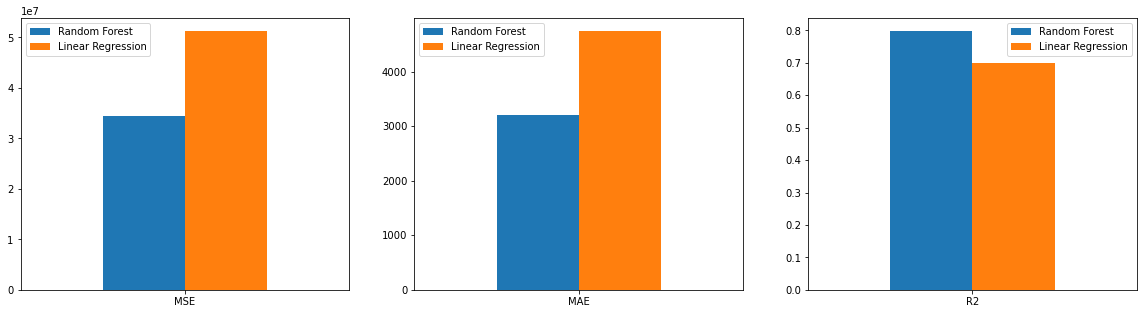

In [199]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

### This tests confirms that Random Forest is the better regression model with lower MSE and MAE and higher R2.

# 5. Try Linear Discriminant Analysis,Truncated SVD, Factor Analysis- Filters methods of Dimensionality Reduction Techniques with the Linear Regression pipeline and Random Forest pipeline

## 5.1. Random Forest

In [220]:
#Random Forest Pipeline
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

 

param_grid = [
     {
        'reduce_dim': [LDA(n_components=1)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
         'regresson__max_depth': MAX_DEPTH_OPTIONS
     },
    {
        'reduce_dim': [FactorAnalysis(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [TruncatedSVD(random_state=42)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }
]

search = GridSearchCV(pipe_rf, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.722:
Best parameters:  {'reduce_dim': TruncatedSVD(n_components=6, random_state=42), 'reduce_dim__n_components': 6, 'regresson__max_depth': 8}


## 5.2. Linear Regression

In [210]:

N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [LDA(n_components=1)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [TruncatedSVD(random_state=42)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
      {
        'reduce_dim': [FactorAnalysis(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }
]

search = GridSearchCV(pipe_lr, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.736:
Best parameters:  {'reduce_dim': TruncatedSVD(n_components=6, random_state=42), 'reduce_dim__n_components': 6, 'regresson__normalize': False}


## 5.3 Compare Regression Models on Test Set

In [223]:
RF_mse_new, RF_mae_new, RF_r2_new = evaluate_model(X_test, y_test, RF_best_model)
LR_mse_new, LR_mae_new, LR_r2_new = evaluate_model(X_test, y_test, LR_best_model)

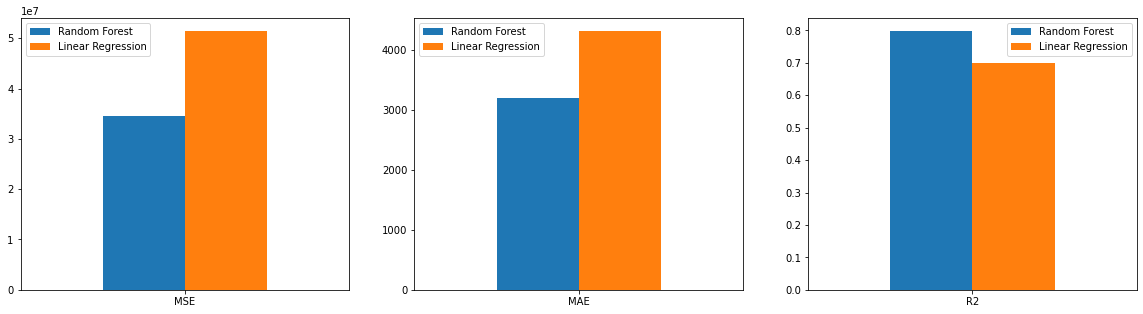

In [224]:
df_mse_new = pd.DataFrame({'Random Forest': RF_mse_new, 'Linear Regression': LR_mse_new}, index=['MSE'])
df_mae_new = pd.DataFrame({'Random Forest': RF_mae_new, 'Linear Regression': LR_mae_new}, index=['MAE'])
df_r2_new = pd.DataFrame({'Random Forest': RF_r2_new, 'Linear Regression': LR_r2_new}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse_new.plot.bar(rot=0, ax=axes[0])
df_mae_new.plot.bar(rot=0, ax=axes[1])
df_r2_new.plot.bar(rot=0, ax=axes[2])

plt.show()

This tests confirms that Random Forest is better than the Linear Regression model with lower MSE and MAE and higher R2. However, does not change much with changing the dimensionality reduction technique.

# 6.New Regression ModelTry Gradient Boost Regressor

In [225]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', GradientBoostingRegressor())])

In [227]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [LDA(n_components=1)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
        
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS
        
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
GBR_best_params = search.best_params_
GBR_best_model = search.best_estimator_

Best CV score = 0.874:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11}


### Observation, between filter and wrapper methods of dimensionality reduction techniques wrapper methods is the best method found using Grid Search CV
### i.e Recursive Feature Elimination (RFE)

## 6.1. Comparing the New Regression Model on Test Set


In [229]:
GBR_mse, GBR_mae, GBR_r2 = evaluate_model(X_test, y_test, GBR_best_model)

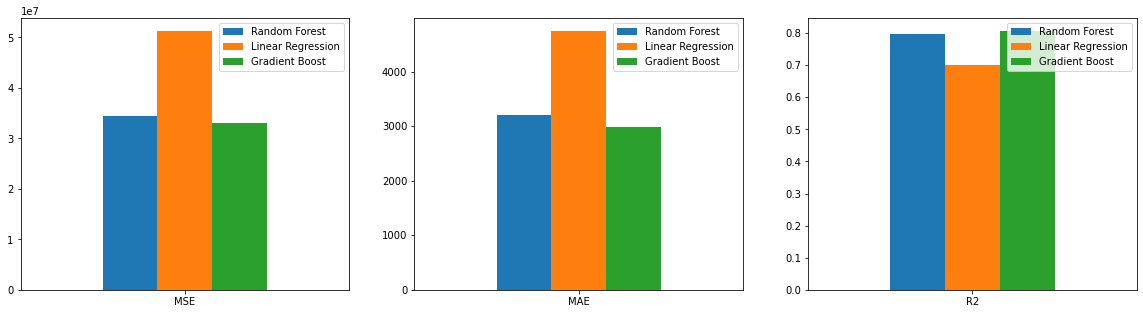

In [230]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'Gradient Boost': GBR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'Gradient Boost': GBR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'Gradient Boost': GBR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

### From the above plot, it is evident that Random Forest and Gradient Boost are better models with higher R2 and lower MSE and MAE. 
### The MAE and MSE for gradient boost is lower than that of Random Forest. Hence, we shall train the final model with Gradient Boost Regression Model.

# 7. Train the Final Model

In [231]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     GBR_best_params.get('reduce_dim'),
                     GradientBoostingRegressor(n_estimators=10, **transform(GBR_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [232]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))